In [1]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2021-12-03 11:43:27.400551: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-03 11:43:27.400572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_parquet("Skim_neweta.parquet")

In [3]:
df["label"] = 0
df = df[df['weight']>0]

In [4]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [5]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [6]:
batch_size = 128


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [7]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.000778 [30.501 events] 
	... background :  5314.822312 [97.499 events]


In [8]:
print(df)

        weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0     0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     0.000025  1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.000025  0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4     0.000025 -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...       ...        ...         ...       ...       ...   
3691  0.784736  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692  0.784736 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.784736  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.784736  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  0.784736  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2

In [9]:
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
df.loc[df['label']==1,'weight'] *= df.shape[0]/2 / df[df['label']==1]['weight'].sum() 
df.loc[df['label']==0,'weight'] *= df.shape[0]/2 / df[df['label']==0]['weight'].sum()
# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1
print ("After equalization")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

print (f'Average learning weight = {df["weight"].mean()}')

print ('\nNow let us try again with batches')

Sum of learning weight for signal     =         1.62564
Sum of learning weight for background =  11460936.00000
After equalization
Sum of learning weight for signal     =    133674.53125
Sum of learning weight for background =    133674.51562
Average learning weight = 1.0

Now let us try again with batches


In [10]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :    64.269911 [30.651 events] 
	... background :    55.274731 [97.349 events]


In [11]:
input_vars=["Eta_ph1","Phi_ph1","E_mGG_ph1","pT_mGG_ph1","Eta_ph2","Phi_ph2","E_mGG_ph2","pT_mGG_ph2","Electron_E","Electron_pT","Electron_Eta","Electron_Phi","Muon_E","Muon_pT","Muon_Eta","Muon_Phi","nJets","E_jet1","pT_jet1","Eta_jet1","Phi_jet1","E_jet2","pT_jet2","Eta_jet2","Phi_jet2","InvM_jet","InvM_jet2", "met"]

In [12]:
print(df[input_vars])

       Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0    -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
1     1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
2     2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
3     0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
4    -0.222354  0.316651   2.682673    2.617695  0.326127  0.229977   
...        ...       ...        ...         ...       ...       ...   
3691  1.767487 -2.685603   2.533158    0.840620  2.022784  1.191282   
3692 -0.761641 -1.350025   1.366371    1.047554 -2.588544 -0.412600   
3693  0.137637  2.189009   0.688119    0.681652  1.682014  0.102387   
3694  0.118838 -2.689873   0.456992    0.453784 -2.057512  0.021551   
3695  1.119464  2.110899   1.128419    0.665800  1.023254 -1.432882   

      E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
0      2.815203    0.482479   32.269810    30.670956  ...   75.722549   
1

In [13]:
df_clean = df[input_vars].copy()
df_clean["label"] = df.loc[:,"label"]
df_clean.to_csv("dataframe_HHWWgg.csv")


In [14]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.weight, 
                                                    test_size=0.33, random_state=42)

In [15]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
35231  -1.945764 -3.062029   2.268816    0.635358 -0.550223 -2.298545   
8868   -1.820626 -0.043045   2.502725    0.789796 -2.617009 -2.681274   
71095   0.099085 -0.838356   0.544916    0.542252  0.862605  2.181485   
114269  1.282274 -2.663917   3.101353    1.597716  0.192350 -2.408060   
36454   1.539533 -1.002441   1.515589    0.621539  1.482318  1.691988   
...          ...       ...        ...         ...       ...       ...   
81876   0.373729 -2.581681   0.944210    0.881901  0.192384 -0.985424   
46     -2.201052 -2.005043   2.970534    0.649638 -1.052876  1.749613   
99997  -1.264996 -1.493569   0.969339    0.506802  0.020675  2.340647   
122596  0.644087 -2.541043   1.332074    1.096632 -0.388746  2.307051   
85023   1.311740  2.135893   2.354585    1.182620  0.749861 -0.459073   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
35231    0.640226    0.554198    0.000000     0.

In [16]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
3329    1.087376  0.904130   0.406792    0.246274 -1.648648 -3.020724   
2789    0.358049 -0.526940   0.437181    0.410581 -1.190133  2.006132   
15599  -1.195990 -2.027550   1.659136    0.919384 -1.642366  2.936179   
64363   1.061911 -2.731441   1.322440    0.816904  0.518941 -1.094325   
4149    1.903018 -1.843503   7.791508    2.273160  2.293625 -0.882963   
...          ...       ...        ...         ...       ...       ...   
2479   -0.581940  2.039370   0.636352    0.541964  0.964338 -2.795501   
126114 -1.491346  0.421756   3.139447    1.345052 -0.678817 -1.530567   
21718   1.412178  2.301200   1.858807    0.854919  0.758501  0.108824   
102035  0.152458 -2.928749   1.387487    1.371517 -0.176697  1.881357   
139654  0.053975  1.505935   0.673873    0.672893  0.499380 -1.281240   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
3329     0.647501    0.240160    0.000000     0.

In [39]:
parameters = {
    'epochs'                : 100,
    'lr'                    : 0.001,
    'batch_size'            : 128,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [40]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [41]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Adam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()

# Callbacks #
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0, 
                               patience = 50,
                               verbose=2,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from history import LossHistory, PlotHistory
loss_history = LossHistory()
# Custom record of the history to add debug plots 

X_val = X_train[-3000:]
y_val = y_train[-3000:]
w_val = w_train[-3000:]
X_train = X_train[:-3000]
y_train = y_train[:-3000]
w_train = w_train[:-3000]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3712      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 53,377
Trainable params: 53,377
Non-trainable

/home/donertas/.local/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [42]:
X_val = X_train[-3000:]
y_val = y_train[-3000:]
w_val = w_train[-3000:]
X_train = X_train[:-3000]
y_train = y_train[:-3000]
w_train = w_train[:-3000]

from history import LossHistory, PlotHistory
loss_history = LossHistory()
# Custom record of the history to add debug plots 


In [43]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
35231  -1.945764 -3.062029   2.268816    0.635358 -0.550223 -2.298545   
8868   -1.820626 -0.043045   2.502725    0.789796 -2.617009 -2.681274   
71095   0.099085 -0.838356   0.544916    0.542252  0.862605  2.181485   
114269  1.282274 -2.663917   3.101353    1.597716  0.192350 -2.408060   
36454   1.539533 -1.002441   1.515589    0.621539  1.482318  1.691988   
...          ...       ...        ...         ...       ...       ...   
88536   1.508294 -1.724887   2.547627    1.074880  1.595690  2.271260   
18108  -1.797871 -2.109140   1.656472    0.534136 -1.977367  0.707362   
1479   -1.922351 -0.857781   3.719852    1.065360 -1.206948  2.422850   
111474 -1.358094 -0.896931   2.183258    1.053207 -2.125977  1.534581   
46305   1.312004 -0.904001   2.279804    1.144800  1.928850 -1.693511   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
35231    0.640226    0.554198    0.000000     0.

In [44]:
history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val,w_val),
    callbacks = [early_stopping,reduce_plateau,loss_history],
)


Epoch 1/100
1259/1259 - 3s - loss: 2.0041 - binary_accuracy: 0.4301 - auc_2: 0.5190 - precision_2: 0.2576 - recall_2: 0.7361 - val_loss: 3.2488 - val_binary_accuracy: 0.4593 - val_auc_2: 0.4696 - val_precision_2: 0.2148 - val_recall_2: 0.4603 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 2/100
1259/1259 - 2s - loss: 1.0112 - binary_accuracy: 0.4257 - auc_2: 0.5173 - precision_2: 0.2578 - recall_2: 0.7470 - val_loss: 0.9706 - val_binary_accuracy: 0.5487 - val_auc_2: 0.6205 - val_precision_2: 0.3116 - val_recall_2: 0.7068 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 3/100
1259/1259 - 2s - loss: 0.9682 - binary_accuracy: 0.4160 - auc_2: 0.5192 - precision_2: 0.2573 - recall_2: 0.7657 - val_loss: 1.2077 - val_binary_accuracy: 0.3510 - val_auc_2: 0.5051 - val_precision_2: 0.2590 - val_recall_2: 0.8959 - lr: 0.0010 - 2s/epoch - 2ms/step
Epoch 4/100
1259/1259 - 2s - loss: 0.5560 - binary_accuracy: 0.4294 - auc_2: 0.5467 - precision_2: 0.2672 - recall_2: 0.7969 - val_loss: 0.6100 - val_binary_accuracy:

Epoch 31/100
1259/1259 - 3s - loss: 0.3396 - binary_accuracy: 0.4291 - auc_2: 0.6379 - precision_2: 0.2747 - recall_2: 0.8473 - val_loss: 0.2775 - val_binary_accuracy: 0.4100 - val_auc_2: 0.6816 - val_precision_2: 0.2768 - val_recall_2: 0.8836 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 32/100
1259/1259 - 3s - loss: 0.3336 - binary_accuracy: 0.4315 - auc_2: 0.6471 - precision_2: 0.2767 - recall_2: 0.8546 - val_loss: 0.6592 - val_binary_accuracy: 0.4047 - val_auc_2: 0.5789 - val_precision_2: 0.2684 - val_recall_2: 0.8384 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 33/100
1259/1259 - 3s - loss: 0.3264 - binary_accuracy: 0.4405 - auc_2: 0.6517 - precision_2: 0.2798 - recall_2: 0.8525 - val_loss: 0.2687 - val_binary_accuracy: 0.4313 - val_auc_2: 0.6701 - val_precision_2: 0.2854 - val_recall_2: 0.8890 - lr: 0.0010 - 3s/epoch - 2ms/step
Epoch 34/100
1259/1259 - 3s - loss: 0.3037 - binary_accuracy: 0.4467 - auc_2: 0.6657 - precision_2: 0.2843 - recall_2: 0.8670 - val_loss: 0.4307 - val_binary_accur

Epoch 60/100
1259/1259 - 3s - loss: 0.1942 - binary_accuracy: 0.4091 - auc_2: 0.7320 - precision_2: 0.2808 - recall_2: 0.9435 - val_loss: 0.2443 - val_binary_accuracy: 0.4003 - val_auc_2: 0.7385 - val_precision_2: 0.2817 - val_recall_2: 0.9452 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 61/100
1259/1259 - 3s - loss: 0.1914 - binary_accuracy: 0.4070 - auc_2: 0.7315 - precision_2: 0.2802 - recall_2: 0.9446 - val_loss: 0.2562 - val_binary_accuracy: 0.4200 - val_auc_2: 0.7465 - val_precision_2: 0.2889 - val_recall_2: 0.9466 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 62/100
1259/1259 - 3s - loss: 0.1898 - binary_accuracy: 0.4058 - auc_2: 0.7331 - precision_2: 0.2800 - recall_2: 0.9466 - val_loss: 0.2420 - val_binary_accuracy: 0.3957 - val_auc_2: 0.7349 - val_precision_2: 0.2809 - val_recall_2: 0.9507 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 63/100
1259/1259 - 3s - loss: 0.1879 - binary_accuracy: 0.4069 - auc_2: 0.7343 - precision_2: 0.2807 - recall_2: 0.9485 - val_loss: 0.2369 - val_

Epoch 89/100
1259/1259 - 3s - loss: 0.1618 - binary_accuracy: 0.4319 - auc_2: 0.7502 - precision_2: 0.2908 - recall_2: 0.9575 - val_loss: 0.2218 - val_binary_accuracy: 0.4250 - val_auc_2: 0.7535 - val_precision_2: 0.2918 - val_recall_2: 0.9548 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 90/100
1259/1259 - 3s - loss: 0.1625 - binary_accuracy: 0.4266 - auc_2: 0.7490 - precision_2: 0.2890 - recall_2: 0.9590 - val_loss: 0.2158 - val_binary_accuracy: 0.4633 - val_auc_2: 0.7529 - val_precision_2: 0.3039 - val_recall_2: 0.9342 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 91/100
1259/1259 - 3s - loss: 0.1617 - binary_accuracy: 0.4286 - auc_2: 0.7479 - precision_2: 0.2895 - recall_2: 0.9571 - val_loss: 0.2198 - val_binary_accuracy: 0.4660 - val_auc_2: 0.7642 - val_precision_2: 0.3060 - val_recall_2: 0.9425 - lr: 1.0000e-04 - 3s/epoch - 2ms/step
Epoch 92/100
1259/1259 - 3s - loss: 0.1598 - binary_accuracy: 0.4337 - auc_2: 0.7486 - precision_2: 0.2912 - recall_2: 0.9552 - val_loss: 0.2164 - val_

Curves saved as Loss_OUBFPSFZFX.png


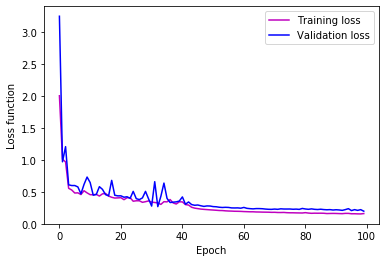

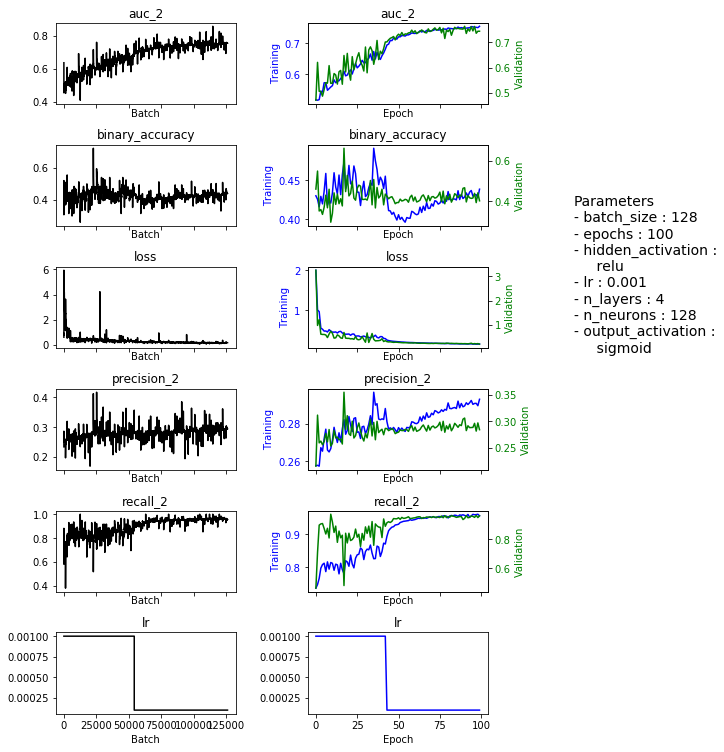

In [45]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


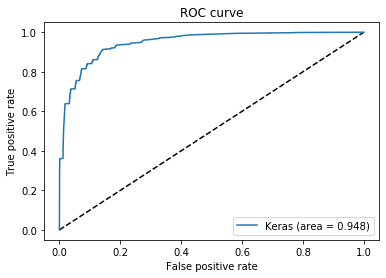

In [46]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()


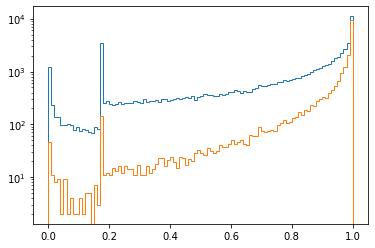

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],histtype=("step"),bins=100)
plt.hist(prediction[y_test==1],histtype=("step"),bins=100)
plt.yscale('log') 
fig.savefig("prediction.pdf", dpi = 300)

In [ ]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# save model and architecture to single file
model.save("model_dnn_neweta")
print("Saved model to disk")